In [1]:
import numpy as np
import torch

import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cpu")

# Load data:

In [3]:
data = np.load('XRF_sample1.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'XRF_sample1.npy'

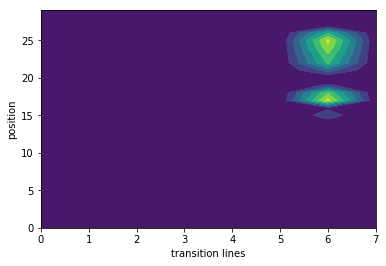

In [197]:
plt.contourf(data[3,:,:]) # Third angle:
plt.xlabel('transition lines')
plt.ylabel('position')
plt.show()

# Test how reshape works:

In [138]:
batch_size=6

a=np.arange(1,241)
print(a.shape)

b=a.reshape(30, 8)
print(b.shape)

c=b.reshape(batch_size, b.shape[0]//batch_size, -1)
print(c[0])

(240,)
(30, 8)
[[ 1  2  3  4  5  6  7  8]
 [ 9 10 11 12 13 14 15 16]
 [17 18 19 20 21 22 23 24]
 [25 26 27 28 29 30 31 32]
 [33 34 35 36 37 38 39 40]]


# Make mini-batch:

In [139]:
batch_size=6

# Take first angle:
angle = data[0]

# Reshape
second_dim = angle.shape[0]//batch_size
y = angle.reshape(batch_size, second_dim, -1)
y.shape

(6, 5, 8)

# Inherit nn.Module to make our own model:

In [177]:
class PPM(nn.Module):
    def __init__(self, N, M, L):
        """
        Initialize the attributes of PPM.
        """
        super(PPM, self).__init__() # inherit the __init__ from nn.Module.
        
        self.N = N                  # N should be y.shape[1].
        self.M = M                  # M is the number of elements.
        self.L = L                  # L should be y.shape[2].
        self.x = self.init_x()  # initialize self.x with method init_x().
        
    def init_x(self):
        """
        Initialize self.x with 5x5 zero tensor.
        """
        return nn.Parameter(torch.zeros(self.N, self.M))
    
    def F(self, h):
        """
        Some function which would not change during training. This function is going to convert self.x to 
        the correct dimension as y. Here we use matrix multiplication as an example.
        """
        M = torch.randn(self.M, self.L)
        return torch.matmul(h, M)
        
    def forward(self):
        """
        Forward propagation.
        """
        output = self.F(self.x)
        return output

In [163]:
list(model.parameters())[0]

Parameter containing:
tensor([[ 2.2699e-03, -2.2676e-03,  2.2418e-03,  2.4104e-03,  2.1929e-03],
        [ 7.2124e-05, -2.2986e-03,  1.0076e-03,  2.4625e-03,  1.1552e-03],
        [ 2.7061e-03, -3.0262e-03,  2.4976e-03,  3.1778e-03,  1.3820e-03],
        [ 1.5009e-03, -2.7303e-03,  1.6107e-03,  2.9473e-03, -8.5535e-04],
        [ 4.1866e-04, -3.2479e-03, -3.4878e-04,  1.4187e-03, -1.5437e-03]],
       requires_grad=True)

In [234]:
Nangle=12

model = PPM(5,5,8).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for i in range(Nangle):
    for j in range(batch_size):
    
        y_true = torch.from_numpy(y[j]).double()
        y_hat = model()
        y_hat = y_hat.double()
    
        loss = loss_fn(y_true, y_hat)
    
        optimizer.zero_grad() # reset gradient
        loss.backward()      # calculate gradient with respect to loss function.
        optimizer.step()      # update model parameters
        
    # Check whether model.parameters() is model.x
    print('Is model.parameters()= model.x?', list(model.parameters())[0] is model.x, '\n') # or print(list(model.parameters())[0] == model.x)
    print('Print model.x', model.x, '\n')
    print('Loss for angle {}: {}'.format(i, loss.item()) )

Is model.parameters()= model.x? True 

Print model.x Parameter containing:
tensor([[ 0.0232, -0.0077,  0.0242,  0.0045, -0.0231],
        [ 0.0121,  0.0129,  0.0019, -0.0126, -0.0242],
        [ 0.0289, -0.0027,  0.0069, -0.0124, -0.0320],
        [ 0.0113,  0.0105,  0.0027, -0.0281, -0.0205],
        [ 0.0149,  0.0011, -0.0208, -0.0276, -0.0253]], requires_grad=True) 

Loss for angle 0: 0.0015877116192486566
Is model.parameters()= model.x? True 

Print model.x Parameter containing:
tensor([[ 0.0363, -0.0123,  0.0407, -0.0045, -0.0493],
        [ 0.0389,  0.0270, -0.0066, -0.0434, -0.0539],
        [ 0.0518,  0.0030,  0.0158, -0.0358, -0.0556],
        [ 0.0338,  0.0170,  0.0114, -0.0527, -0.0427],
        [ 0.0357,  0.0224, -0.0446, -0.0500, -0.0459]], requires_grad=True) 

Loss for angle 1: 0.006236762838791194
Is model.parameters()= model.x? True 

Print model.x Parameter containing:
tensor([[ 3.7309e-02, -2.9125e-02,  2.6433e-02, -2.2444e-02, -6.3496e-02],
        [ 5.5862e-02,  1.

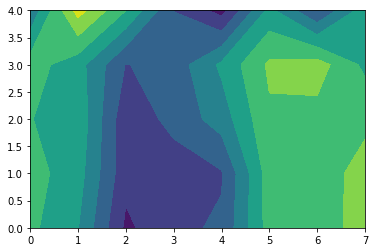

In [229]:
Y=model()
plt.contourf(Y.detach().numpy()) # Remember to detach from the computational graph and convert to numpy in order
                                 # to make plot.
plt.show()